# IMPORT

In [1]:
import os, sys
import numpy as np
import pandas as pd
import datetime as dt
import random

#Optional, ekran genişlesin diye
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

#Optional, pandas display ayarları
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

###  Definitions - Train

In [3]:
def read_and_write_directory(Enronx = '1'):
    """
    Sets paths and creates a list of bugs for each directory
    Enronx indicates the main dataset type number
    """

    path = ['./enron'+Enronx+'/ham', 
            './enron'+Enronx+'/spam']

    list_of_bugs = [os.listdir(directory) for directory in path]
    return list_of_bugs

In [4]:
#Takes a list of directory lists and returns train and test samples
def shuffle_and_create_samples(list_of_bugs):
    """
    Takes a list of directory and returns train and test samples
    Train: %70 of main data
    Test: %30 of main data
    X_train: Train data of real emails
    Y_train: Train data of spam emails
    x_test: Test data of real emails
    y_test: Test data of spam emails
    """
    
    for i in range(0,2):
        random.shuffle(list_of_bugs[i])
        if i == 0:
            X_train =  list_of_bugs[i][:int(len(list_of_bugs[i])*0.70)]
            x_test =  list_of_bugs[i][int(len(list_of_bugs[i])*0.70):]
        else:
            Y_train =  list_of_bugs[i][:int(len(list_of_bugs[i])*0.70)]
            y_test =  list_of_bugs[i][int(len(list_of_bugs[i])*0.70):]
    return X_train, Y_train, x_test, y_test

In [5]:
#Creates a great words list which contains all existing words from train data
def all_words_list(Enronx = '1'):
    """
    Takes all data from 2 different data sets and returns a big list of words and mail type flags
    Enronx indicates the main dataset type number
    """
    
    all_words_list = []
    for sign in ['X','Y']:
        for file_name in tqdm(eval(sign+"_train")):
            if sign == 'X':
                mail = open("./enron"+Enronx+"/ham\\"+file_name,encoding="latin-1")
            elif sign == 'Y':
                mail = open("./enron"+Enronx+"/spam\\"+file_name,encoding="latin-1")
            m = list(set(mail.read().split()))
            all_words_list = all_words_list + m
    all_words_list = list(set(all_words_list))
    words_df = pd.DataFrame(all_words_list, columns = ['Words'])
    # The default value is 1 to be sure any value wouldn't be NaN or too effective
    words_df['ham'], words_df['spam'] = [1,1]
    words_df.set_index('Words', inplace = True)
    return words_df

In [6]:
#Takes a list of mail directories and returns 3 columns dataframe which shows frequencies of each word 
def calculate_frequency(words_df, enronx = '1'):
    
    """
    Takes a DataFrame of all words in main data. 
    Returns the frequency of each word with respect to ham or spam
    Columns:
    index: words
    ham: frequency of a word in real emails
    spam: frequency of a word in spam emails
    """
    for sign in ['X', 'Y']:

        if sign == 'X':
            folder = 'ham'
            index = 1
        elif sign == 'Y':
            folder = 'spam'
            index = 2

        for file_name in tqdm(eval(sign+"_train")):
            mail = open("./enron"+enronx+"/"+folder+"\\"+file_name,encoding="latin-1")
            m = list(set(mail.read().split()))
            try:
                for word in m:
                    words_df.loc[word, folder]  += 1
            except:
                print('The word '+word+' is not available')
    return words_df

In [7]:
#Takes a 3 columns frequency dataframe and returns 3 columns probability dataframe for each word
def calculate_probabilities(words_df):
    """
    Takes a DataFrame of all words with their frequencies with 2 columns: 
    ham: frequency of a word in real emails
    spam: frequency of a word in spam emails
    Returns a probability DataFrame which shows individual probability of existince with respect to ham or spam
    Columns:
    index: Words
    ham: probability of existence of a word in real emails
    spam: probability of existence in spam emails
    
    Calculates frequencies of each word in data according to their type. (ham or spam)
    
    """
    prob_df = words_df.copy()
    for i in tqdm(['ham', 'spam']):
        if i == 'ham':
            k = 0
        elif i == 'spam':
            k = 1
        prob_df[i] = (words_df.iloc[:,k]/(words_df.iloc[:,0] + words_df.iloc[:,1]))
    return prob_df

In [8]:
#Takes a 3 columns frequency dataframe and returns 3 columns probability dataframe for each word
def calculate_probabilities(words_df, X_train, Y_train):
    """
    Takes a DataFrame of all words with their frequencies with 2 columns: 
    ham: frequency of a word in real emails
    spam: frequency of a word in spam emails
    Returns a probability DataFrame which shows individual probability of existince with respect to ham or spam
    Columns:
    index: Words
    ham: probability of existence of a word in real emails
    spam: probability of existence in spam emails
    
    Calculates frequencies of each word in data according to their type. (ham or spam)
    
    """
    prob_df = words_df.copy()
    prob_df['ham'] = words_df['ham']/len(X_train)
    prob_df['spam'] = words_df['spam']/len(Y_train)
    return prob_df

###  Definitions - Test

In [9]:
def test_emails(probability_df,test_list,X_train,Y_train, Enronx = '1', source = 'ham'):
     
    """
    Takes a list of directories
    Returns the predicted type of each directory with respect to spam or ham
    
    Columns:
    index: eMails
    Spam_f: Prediction of if an email is a spam or not

    """
    file_df = pd.DataFrame(test_list, columns = ['Files'])
    file_df['Spam_F'] = 0
    file_df.set_index('Files', inplace = True)  
    
    for file_name in tqdm(test_list):
        mail = open("./enron"+Enronx+"/"+source+"\\"+file_name,encoding="latin-1")
        m = list(set(mail.read().split()))

        multiplier_ham = len(X_train)/(len(Y_train)+len(X_train))
        multiplier_spam = len(Y_train)/(len(Y_train)+len(X_train))
        
        for word in m:
            try:
                ham_prob = probability_df.loc[word, 'ham']
                spam_prob = probability_df.loc[word, 'spam']
                multiplier_ham = multiplier_ham*ham_prob
                multiplier_spam = multiplier_spam*spam_prob                
            except:
                None
        if multiplier_spam > multiplier_ham:
            file_df.loc[file_name] = 1
    return file_df

###  Definitions - Compare

In [10]:
def confusion_matrix(test_x, test_y, matrix_type = 1):
    """
    Takes 2 dataframes from 2 differenct samples: ham and spam emails. 
    Returns the confusion matrix of the predictions
    
    Inputs:
    test_x: ham emails 
    test_y: spam emails
    
    matrix_type:
    1: Shows percentage 
    2: Shows actual numbers

    """

    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sn
    import pandas as pd

    import seaborn as sns
    import math

    from mpl_toolkits.axes_grid1 import make_axes_locatable

    import matplotlib as mpl

    mpl.style.use('seaborn')
    
    #Matrix Dimensions
    #SAG ÜST
    FP = test_x.sum()
    #SOL ÜST
    TN = test_x.count() - FP
    #SAĞ ALT
    TP = test_y.sum()
    #SOL ALT
    FN = test_y.count() - TP
    #Matrix array
    confusion_array = np.array([[FP[0], TN[0]], [TP[0],FN[0]]])

    conf_arr = confusion_array

    sum = conf_arr.sum()

    if matrix_type == 1:
        conf_arr = conf_arr * 100.0 / ( 1.0 * sum )
    elif matrix_type == 2:
        None

    df_cm = pd.DataFrame(conf_arr, 
      index = [ 'No', 'Yes'],
      columns = ['No', 'Yes'])

    fig = plt.figure()

    plt.clf()

    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    cmap = sns.cubehelix_palette(light=1, as_cmap=True)

    res = sn.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='.0f', cmap=cmap)

    res.invert_yaxis()

    plt.yticks([0.5,1.5], ['Yes', 'No'],va='center')

    plt.title('Confusion Matrix')

    return plt.savefig('confusion_matrix.png', dpi=100, bbox_inches='tight' )

In [11]:
#Calculates accuracy by using test dataframes
def accuracy(test_x, test_y):
    """
    Takes 2 dataframes  
    Returns the accuracy of trained model   
    Inputs:
    test_x: ham emails 
    test_y: spam emails
    
    Outputs:
    accuracy: Accuracy of the model (percentage)

    """
    
    #SAG ÜST
    FP = test_x.sum()
    #SOL ÜST
    TN = test_x.count() - FP
    #SAĞ ALT
    TP = test_y.sum()
    #SOL ALT
    FN = test_y.count() - TP
    
    accuracy = (TN + TP) / (TN + TP+FP +FN)
    return accuracy

# Enron1 

## Run Training

In [12]:
#Reads paths and creates a list of directories
list_of_bugs = read_and_write_directory(Enronx = '1')

#Takes a list of directory lists and returns train and test samples
X_train, Y_train, x_test, y_test = shuffle_and_create_samples(list_of_bugs)

#Creates a great words list which contains all existing words from train data
print('Creating: All_words_list')
words_df = all_words_list(Enronx = '1')

#Takes a list of mail directories and returns 3 columns dataframe which shows frequencies of each word
print('Creating: Frequency DataFrame')
words_df = calculate_frequency(words_df, enronx = '1')

X_train_1 = X_train.copy() 
Y_train_1 = Y_train.copy() 
x_test_1 =  x_test.copy()
y_test_1 =  y_test.copy()
 
#Takes a 3 columns frequency dataframe and returns 3 columns probability dataframe for each word
print('Creating: Probability DataFrame')
prob_df = calculate_probabilities(words_df, X_train_1, Y_train_1)

Creating: All_words_list


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Creating: Frequency DataFrame


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Creating: Probability DataFrame


## Run Test

Testing: Ham dataset


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Testing: Spam dataset


Spam_F    0.921392
dtype: float64

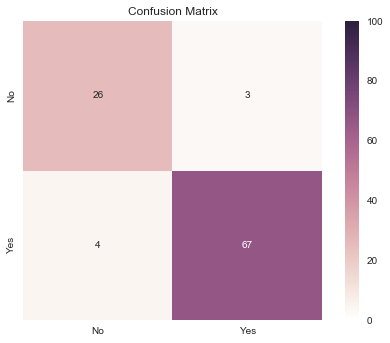

In [13]:
#Test both for x and y test sets
print('Testing: Ham dataset')
test_df_x = test_emails(prob_df, x_test_1,X_train_1, Y_train_1, Enronx = '1', source = 'ham')

print('Testing: Spam dataset')
test_df_y = test_emails(prob_df, y_test_1, X_train_1, Y_train_1, Enronx = '1', source = 'spam')

#Creating a confusion matrix
confusion_matrix(test_df_x, test_df_y, matrix_type = 1)

#Calculates accuracy by using test dataframes
accuracy(test_df_x, test_df_y)

# Enron6

## Run Training

In [14]:
#Reads paths and creates a list of directories
list_of_bugs_6 = read_and_write_directory(Enronx = '6')
#Takes a list of directory lists and returns train and test samples
X_train, Y_train, x_test, y_test = shuffle_and_create_samples(list_of_bugs_6)

#Creates a great words list which contains all existing words from train data
print('Creating: All_words_list')
words_df_6 = all_words_list(Enronx = '6')

#Takes a list of mail directories and returns 3 columns dataframe which shows frequencies of each word
print('Creating: Frequency DataFrame')
words_df_6 = calculate_frequency(words_df_6, enronx = '6')

X_train_6 = X_train.copy() 
Y_train_6 = Y_train.copy() 
x_test_6 =  x_test.copy()
y_test_6 =  y_test.copy()

#Takes a 3 columns frequency dataframe and returns 3 columns probability dataframe for each word
print('Creating: Probability DataFrame')
prob_df6 = calculate_probabilities(words_df_6, X_train_6, Y_train_6)

Creating: All_words_list


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Creating: Frequency DataFrame


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Creating: Probability DataFrame


## Run Test

Testing: Ham dataset


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Testing: Spam dataset


Spam_F    0.796667
dtype: float64

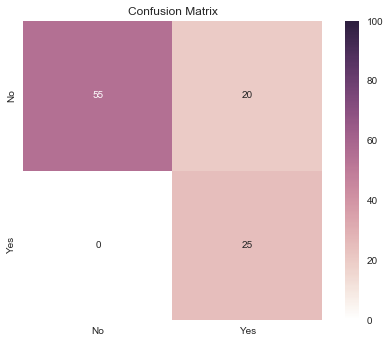

In [15]:
#Test both for x and y test sets
print('Testing: Ham dataset')
test_x6 = test_emails(prob_df6, x_test_6, X_train_6, Y_train_6, Enronx = '6', source = 'ham')

print('Testing: Spam dataset')
test_y6 = test_emails(prob_df6, y_test_6, X_train_6, Y_train_6, Enronx = '6', source = 'spam')

#Creating a confusion matrix
confusion_matrix(test_x6, test_y6, matrix_type = 1)

#Calculates accuracy by using test dataframes
accuracy(test_x6, test_y6)

## Cross Testing

### Enron1 train - Enron6 Test

Testing: Ham dataset


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Testing: Spam dataset


Spam_F    0.802778
dtype: float64

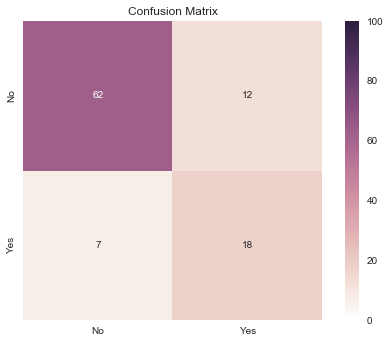

In [16]:
#Test both for x and y test sets
print('Testing: Ham dataset')
test_x7 = test_emails(prob_df, x_test_6, X_train_1, Y_train_1, Enronx = '6', source = 'ham')

print('Testing: Spam dataset')
test_y7 = test_emails(prob_df, y_test_6, X_train_1, Y_train_1, Enronx = '6', source = 'spam')

#Creating a confusion matrix
confusion_matrix(test_x7, test_y7, matrix_type = 1)

#Calculates accuracy by using test dataframes
accuracy(test_x7, test_y7)

### Enron6 train - Enron1 Test

Testing: Ham dataset


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()



Testing: Spam dataset


Spam_F    0.92268
dtype: float64

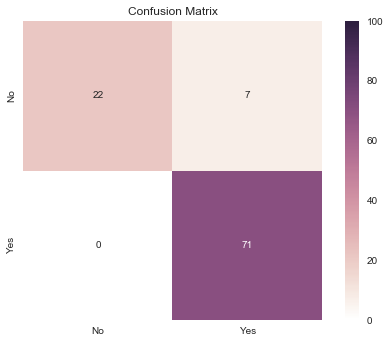

In [17]:
#Test both for x and y test sets
print('Testing: Ham dataset')
test_x2 = test_emails(prob_df6, x_test_1, X_train_6, Y_train_6, Enronx = '1', source = 'ham')

print('Testing: Spam dataset')
test_y2 = test_emails(prob_df6, y_test_1, X_train_6, Y_train_6, Enronx = '1', source = 'spam')

#Creating a confusion matrix
confusion_matrix(test_x2, test_y2, matrix_type = 1)

#Calculates accuracy by using test dataframes
accuracy(test_x2, test_y2)